# Load modules

In [1]:
import os

import imagej
import ipywidgets
import numpy as np
import pandas as np
import scyjava as sj
import skimage
import xarray
from pims import ND2Reader_SDK, pipeline
import matplotlib.pyplot as plt

In [2]:
# Configre ImageJ
sj.config.add_option("-Xmx16g")
sj.config.add_option("-XX:ActiveProcessorCount=1")
ij = imagej.init("sc.fiji:fiji")
print(f"ImageJ version: {ij.getVersion()}")

# Show memory used
Runtime = sj.jimport('java.lang.Runtime')
def java_mem():
    rt = Runtime.getRuntime()
    mem_max = rt.maxMemory()
    mem_used = rt.totalMemory() - rt.freeMemory()
    return '{} of {} MB ({}%)'.format(int(mem_used)/2**20, int(mem_max/2**20), int(100*mem_used/mem_max))

java_mem()

01:26:26.757 [SciJava-37b72ea-Thread-0] DEBUG loci.formats.ClassList - Could not find loci.formats.in.URLReader
java.lang.ClassNotFoundException: loci.formats.in.URLReader
	at java.base/jdk.internal.loader.BuiltinClassLoader.loadClass(BuiltinClassLoader.java:641)
	at java.base/jdk.internal.loader.ClassLoaders$AppClassLoader.loadClass(ClassLoaders.java:188)
	at java.base/java.lang.ClassLoader.loadClass(ClassLoader.java:520)
	at java.base/java.lang.Class.forName0(Native Method)
	at java.base/java.lang.Class.forName(Class.java:375)
	at loci.formats.ClassList.parseLine(ClassList.java:196)
	at loci.formats.ClassList.parseFile(ClassList.java:258)
	at loci.formats.ClassList.<init>(ClassList.java:138)
	at loci.formats.ClassList.<init>(ClassList.java:122)
	at loci.formats.ImageReader.getDefaultReaderClasses(ImageReader.java:80)
	at io.scif.bf.BioFormatsFormat.cacheReaderClasses(BioFormatsFormat.java:538)
	at io.scif.bf.BioFormatsFormat.<init>(BioFormatsFormat.java:139)
	at java.base/jdk.interna

[ERROR] Cannot create plugin: org.scijava.plugins.scripting.javascript.JavaScriptScriptLanguage


'131.0300064086914 of 15837 MB (0%)'

# Preprocessing

## Load nd2 file

/home/liboyan/miniconda3/envs/mt/lib/python3.10/site-packages/pims/base_frames.py:478: UserWarning: Please call FramesSequenceND.__init__() at the start of thethe reader initialization.
  warn("Please call FramesSequenceND.__init__() at the start of the"


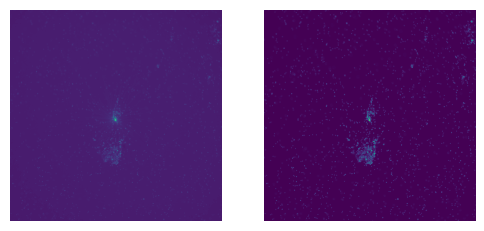

In [3]:
data_dir = "../data/220930/"
data_file = "220930_1um-beads.nd2"
dataset = ND2Reader_SDK(os.path.join(data_dir, data_file))
dataset.iter_axes = "c"
dataset.bundle_axes = "tyx"
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3))
plt.subplots_adjust(hspace=0)
ax1.imshow(dataset[0][0])
ax2.imshow(dataset[1][0])
for ax in [ax1, ax2]:
    ax.axis("off")

## Prepare data for tracking

In [4]:
MT_CHANNEL = 0
TRACK_CHANNEL = 1

print("Sizes of the input data:", dataset.sizes)

xdataset = xarray.DataArray(dataset[TRACK_CHANNEL], name="testimg", dims=("t", "row", "col"))

jxdataset = ij.py.to_imageplus(xdataset)
print("Data type:\t", type(jxdataset))
print("Data shape:\t", jxdataset.shape)
print("Data dimensions:\t", jxdataset.dims)

Sizes of the input data: {'x': 2048, 'y': 2048, 'c': 2, 't': 121}


Operating in headless mode - the original ImageJ will have limited functionality.


Data type:	 <java class 'ij.ImagePlus'>
Data shape:	 (2048, 2048, 121)
Data dimensions:	 ('X', 'Y', 'T')


# Model configurations

In [5]:
# Model
trackmate_model = sj.jimport("fiji.plugin.trackmate.Model")
model = trackmate_model()

# Log
trackmate_logger = sj.jimport("fiji.plugin.trackmate.Logger")
model.setLogger(trackmate_logger.IJ_LOGGER)

# Settings
trackmate_settings = sj.jimport("fiji.plugin.trackmate.Settings")
settings = trackmate_settings(jxdataset)

# Configure detector
LogDetectorFactory = sj.jimport("fiji.plugin.trackmate.detection.LogDetectorFactory")
settings.detectorFactory = LogDetectorFactory()
settings.detectorSettings = {
    "DO_SUBPIXEL_LOCALIZATION": True,
    "RADIUS": 7.0,
    "TARGET_CHANNEL": ij.py.to_java(1),
    "THRESHOLD": 0.0,
    "DO_MEDIAN_FILTERING": True,
}

# Spot filter
trackmate_featurefilter = sj.jimport("fiji.plugin.trackmate.features.FeatureFilter")
filter1 = trackmate_featurefilter("QUALITY", 30, True)
settings.addSpotFilter(filter1)

In [6]:
TrackMate = sj.jimport("fiji.plugin.trackmate.TrackMate")
trackmate = TrackMate(model, settings)

In [7]:
if not trackmate.process():
    print(str(trackmate.getErrorMessage()))

Starting detection process using 1 thread.



[java.lang.Enum.toString] Starting detection process using 1 thread.
[java.lang.Enum.toString] 


Detection processes 1 frame simultaneously and allocates 1 thread per frame.



[java.lang.Enum.toString] Detection processes 1 frame simultaneously and allocates 1 thread per frame.
[java.lang.Enum.toString] 


Found 1070660 spots.

Starting initial filtering process.



[java.lang.Enum.toString] Found 1070660 spots.
[java.lang.Enum.toString] 
[java.lang.Enum.toString] Starting initial filtering process.
[java.lang.Enum.toString] 


Computing spot features over 1 frame simultaneously and allocating 1 thread per frame.

Computation done in 2058 ms.

Starting spot filtering process.

Starting tracking process.

Tracker factory is not defined. Skipping tracking.

Computing edge features:

Computation done in 0 ms.

Computing track features:

Computation done in 1 ms.

Starting track filtering process.



[java.lang.Enum.toString] Computing spot features over 1 frame simultaneously and allocating 1 thread per frame.
[java.lang.Enum.toString] 
[java.lang.Enum.toString] Computation done in 2058 ms.
[java.lang.Enum.toString] 
[java.lang.Enum.toString] Starting spot filtering process.
[java.lang.Enum.toString] 
[java.lang.Enum.toString] Starting tracking process.
[java.lang.Enum.toString] 
[java.lang.Enum.toString] Tracker factory is not defined. Skipping tracking.
[java.lang.Enum.toString] 
[java.lang.Enum.toString] Computing edge features:
[java.lang.Enum.toString] 
[java.lang.Enum.toString] Computation done in 0 ms.
[java.lang.Enum.toString] 
[java.lang.Enum.toString] Computing track features:
[java.lang.Enum.toString] 
[java.lang.Enum.toString] Computation done in 1 ms.
[java.lang.Enum.toString] 
[java.lang.Enum.toString] Starting track filtering process.
[java.lang.Enum.toString] 


In [1]:
fm = model.getFeatureModel()
print(fm)

NameError: name 'model' is not defined

# Tracking

In [7]:
# Tracker
SparseLAPTrackerFactory = sj.jimport(
    "fiji.plugin.trackmate.tracking.sparselap.SparseLAPTrackerFactory"
)
LAPUtils = sj.jimport("fiji.plugin.trackmate.tracking.LAPUtils")
settings.trackerFactory = SparseLAPTrackerFactory()
settings.trackerSettings = LAPUtils.getDefaultLAPSettingsMap()  # almost good enough
settings.trackerSettings['LINKING_MAX_DISTANCE'] = 7.0
settings.trackerSettings['GAP_CLOSING_MAX_DISTANCE'] = 10.0
settings.trackerSettings['MAX_FRAME_GAP'] = 3
settings.addAllAnalyzers()

# Filter tracks
filter2 = trackmate_featurefilter("TRACK_DISPLACEMENT", 10, True)
settings.addTrackFilter(filter2)

TrackMate = sj.jimport("fiji.plugin.trackmate.TrackMate")
trackmate = TrackMate(model, settings)

# Export results

In [84]:
model.getLogger().log("Found " + str(model.getTrackModel().nTracks(True)) + " tracks.")

# The feature model, that stores edge and track features.
fm = model.getFeatureModel()

# Iterate over all the tracks that are visible.
for id in model.getTrackModel().trackIDs(True):

    # Fetch the track feature from the feature model.
    v = fm.getTrackFeature(id, "TRACK_MEAN_SPEED")
    model.getLogger().log("")
    model.getLogger().log(
        "Track "
        + str(id)
        + ": mean velocity = "
        + str(v)
        + " "
        + str(model.getSpaceUnits())
        + "/"
        + str(model.getTimeUnits())
    )

    # Get all the spots of the current track.
    track = model.getTrackModel().trackSpots(id)
    for spot in track:
        sid = spot.ID()
        # Fetch spot features directly from spot.
        # Note that for spots the feature values are not stored in the FeatureModel
        # object, but in the Spot object directly. This is an exception; for tracks
        # and edges, you have to query the feature model.
        x = spot.getFeature("POSITION_X")
        y = spot.getFeature("POSITION_Y")
        t = spot.getFeature("FRAME")
        q = spot.getFeature("QUALITY")
        snr = spot.getFeature("SNR_CH1")
        mean = spot.getFeature("MEAN_INTENSITY_CH1")
        model.getLogger().log(
            "\tspot ID = "
            + str(sid)
            + ": x="
            + str(x)
            + ", y="
            + str(y)
            + ", t="
            + str(t)
            + ", q="
            + str(q)
            + ", snr="
            + str(snr)
            + ", mean = "
            + str(mean)
        )

Found 0 tracks.

[java.lang.Enum.toString] Found 0 tracks.[java.lang.Enum.toString] 


In [ ]:
def plane(image, pos):
    p = tuple(
        pos[image.dims[d]] if image.dims[d] in pos else slice(None)
        for d in range(image.ndim)
    )
    return image[p]


def ndshow(image, cmap=None, immediate=False):
    widgets = {}
    for d in range(image.ndim):
        if image.dims[d].lower() == "x" or image.dims[d].lower() == "y":
            continue
        label = image.dims[d]
        widgets[label] = ipywidgets.IntSlider(
            description=label, max=image.shape[d] - 1, continuous_update=immediate
        )

    def recalc(**kwargs):
        ij.py.show(plane(image, kwargs), cmap=cmap)

    ipywidgets.interact(recalc, **widgets)


ndshow(jxdataset)

# *Supplementary: parameters for TrackMate*

## Tracker settings

In [30]:
SparseLAPTrackerFactory = sj.jimport(
    "fiji.plugin.trackmate.tracking.sparselap.SparseLAPTrackerFactory"
)
LAPUtils = sj.jimport("fiji.plugin.trackmate.tracking.LAPUtils")
settings.trackerFactory = SparseLAPTrackerFactory()
settings.trackerSettings = LAPUtils.getDefaultLAPSettingsMap()  # almost good enough
for k, v in settings.trackerSettings.items():
    print(k, "\t", v)

MAX_FRAME_GAP 	 2
ALTERNATIVE_LINKING_COST_FACTOR 	 1.05
LINKING_FEATURE_PENALTIES 	 {}
LINKING_MAX_DISTANCE 	 15.0
GAP_CLOSING_MAX_DISTANCE 	 15.0
MERGING_FEATURE_PENALTIES 	 {}
SPLITTING_MAX_DISTANCE 	 15.0
BLOCKING_VALUE 	 inf
ALLOW_GAP_CLOSING 	 True
ALLOW_TRACK_SPLITTING 	 False
ALLOW_TRACK_MERGING 	 False
MERGING_MAX_DISTANCE 	 15.0
SPLITTING_FEATURE_PENALTIES 	 {}
CUTOFF_PERCENTILE 	 0.9
GAP_CLOSING_FEATURE_PENALTIES 	 {}
